# CS280 Programming Assignment 4
__Cocktail Party Problem__<br>
<br>
Compiler: Python 3.6.5<br>
OS: Windows 7 64-bit

## 1. Load the audio files mic1.wav to mic5.wav found in the folder Audio_Data. 
These files are synchronized audio recordings captured by five microphones positioned at five different locations

In [1]:
import scipy.io.wavfile as wav
import os

data_path = './Audio_Data'

sampling_freq, mic1_data = wav.read(os.path.join(data_path, 'mic1.wav'))
sampling_freq, mic2_data = wav.read(os.path.join(data_path, 'mic2.wav'))
sampling_freq, mic3_data = wav.read(os.path.join(data_path, 'mic3.wav'))
sampling_freq, mic4_data = wav.read(os.path.join(data_path, 'mic4.wav'))
sampling_freq, mic5_data = wav.read(os.path.join(data_path, 'mic5.wav'))

## 2. Form the mixture matrix X from the input files

In [3]:
import numpy as np

X = np.array([mic1_data, mic2_data, mic3_data, mic4_data, mic5_data])
X = np.transpose(X)/X.std(axis=1)


In [4]:
X.shape

(191258, 5)

In [17]:
import sounddevice as sd
sd.play(0.1*X[:, 0], sampling_freq)

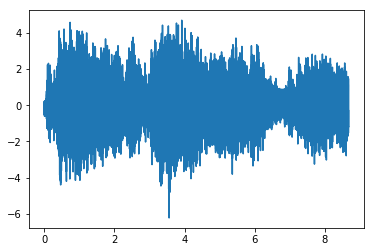

In [10]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0, len(X[:,0])/sampling_freq, 1/sampling_freq)
plt.plot(t, X[:,0])
plt.show()

## 3. Invoke the appropriate ICA command
that "unmixes" the five independent components from the mixture of audio signals. Experiment on the ff:
* appropriate input sampling rate
* whether centering is required
* whether whitening is necessary
* appropriate contrastive function G(y)

First, let's define a function that plays the unmixed components which are outputted by FastICA:

In [7]:
import sounddevice as sd
import time

def play_independent_components(S, sampling_freq):
    print('========================================================================================')
    print('INFO: Turn your volume up to listen to the separated components! (Earphones recommended)')
    print('========================================================================================')
    S = np.transpose(S)
    for index, component in enumerate(S):
        print('Playing component %d:' % (index+1))
        sd.play(component, sampling_freq)
        time.sleep(len(component)/sampling_freq + 1)
    print('Done!')
    


Before trying anything out, let's check if our data is already centered:

In [8]:
means = np.mean(X, axis=0)
print('means: ', means)

means:  [-4.78217954e-08 -1.79852265e-07 -7.77710164e-08  4.03623969e-09
 -3.21318801e-08]


The means of the mixed sound files seem to be very close to zero. Therefore we can consider the data centered by default.

####  Try default settings
* centering: yes
* whitening: yes
* G(y): logcosh (default)

In [19]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=X.shape[-1])
S = ica.fit_transform(X)

In [ ]:
play_independent_components(50*S, sampling_freq)

INFO: Turn your volume up to listen to the separated components! (Earphones recommended)
Playing component 1:
Playing component 2:


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0, len(S[:,0])/sampling_freq, 1/sampling_freq)
plt.plot(t, 100*S[:,0])
plt.show()

####  Try removing centering
* centering: no
* whitening: yes
* G(y): logcosh (default)

In [ ]:
def whiten(X):
    X = np.transpose(X)
    Cx = np.cov(X)
    print(Cx)
    V = 2*(1/np.sqrt(np.absolute(Cx)))
    print(V.shape)
    print(V)
    print(X.shape)
    X_whitened = np.matmul(V, X)
    print(np.transpose(X_whitened).shape)
    print(X_whitened)
    return np.transpose(X_whitened)

In [ ]:
X_not_centered = X - 10000*np.random.uniform(low=-5, high=5, size=(1, X.shape[-1]))
print('means: ', np.mean(X_not_centered, axis=0))

ica = FastICA(n_components=X.shape[-1])
S = ica.fit_transform(X_not_centered)

In [ ]:
play_independent_components(S, sampling_freq)

In [ ]:
X.shape